# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

O objetivo deste notebook é ilustrar 
- o uso do gradiente estocástico por mini-batchs
- utilizando as classes Dataset e DataLoater.

A apresentação da perda nos gráficos é um pouco diferente da usual, mostrando a perda de cada um dos vários minibatches dentro de cada época, de forma que as épocas são apresentadas com valores fracionários.

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST

## Dataset e dataloader

### Definição do tamanho do minibatch

In [2]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [3]:
dataset_dir = '/data/datasets/MNIST/'

dataset_train = MNIST(dataset_dir, train=True, download=False,
                      transform=torchvision.transforms.ToTensor())

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 1200

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


### Usando apenas 1000 amostras do MNIST

Neste exemplo utilizaremos 1000 amostras de treinamento.

In [4]:
if True:
    n_samples_train = 1000

    dataset_train.train_data = dataset_train.train_data[:n_samples_train]
    dataset_train.train_labels = dataset_train.train_labels[:n_samples_train]

print('Número de minibatches de trenamento:', len(loader_train))
n_batches_train = len(loader_train)
total_samples = dataset_train.train_data.size(0)

Número de minibatches de trenamento: 20


## Modelo

In [5]:
model = torch.nn.Linear(28*28, 10)


## Treinamento

### Inicialização dos parâmetros

In [6]:
n_epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Laço de treinamento dos parâmetros

In [7]:
epochs = []
losses = []

total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / total_samples)
        losses.append(loss.item())
    print('Época: {:d}/{:d}'.format(i,n_epochs-1), end='\r')


In [8]:
print('Final loss:', loss.item())

Final loss: 0.16769789159297943


### Visualizando gráfico de perda durante o treinamento

Text(0.5,0,'época')

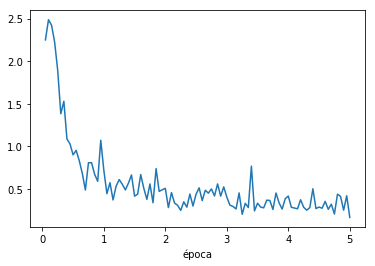

In [9]:
plt.plot(epochs, losses)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5,0,'época')

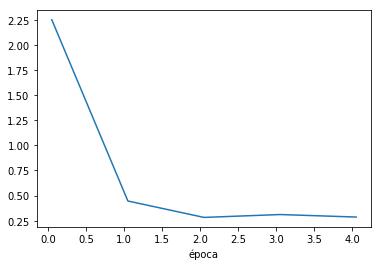

In [10]:
plt.plot(epochs[:5 * n_batches_train +1:n_batches_train], losses[:5 * n_batches_train+1:n_batches_train])
plt.xlabel('época')

# Atividades

## Perguntas

1. Qual é o tamanho do mini-batch?
2. Em uma época, quantos mini-batches existem?
3. Qual é a definição de época?

## Exercícios


1. Coloque um print no final de cada minibatch, no mesmo estilo do print do final de época, no seguinte estilo:
    - Época: 1/4, batch: 3/10
2. Altere o tamanho de minibatch (batch_size) algumas vezes, refaça o treinamento, e compare no gráfico abaixo a queda da perda para cada tamanho de minibatch.

## Conclusões sobre os experimentos deste notebook
